# SPGR

In [1]:
from multiprocessing import set_start_method
set_start_method('forkserver')

In [2]:
import version_control

Last run on cashlab03-deb at 2015-04-30 15:39:50.946454

Phypno Version: 8023f72fc0103da73ab29ab48be1f6a1ed0f7539

Babel==1.3, Cython==0.22, Jinja2==2.7.3, Markdown==2.6.2, MarkupSafe==0.23, Pillow==2.8.1, PyOpenGL==3.1.0, Pygments==2.0.2, Sphinx==1.3.1, alabaster==0.7.3, bash-kernel==0.3, beautifulsoup4==4.3.2, biopython==1.65, certifi==2015.04.28, coverage==3.7.1, decorator==3.4.2, docutils==0.12, easydev==0.8.3, ipython==3.1.0, jedi==0.9.0, jsonschema==2.4.0, matplotlib==1.4.3, memory-profiler==0.32, mistune==0.5.1, networkx==1.9.1, nibabel==2.0.0, nitime==0.5, nltk==3.0.2, nose==1.3.6, numpy==1.9.2, numpydoc==0.5, ordereddict==1.1, pandas==0.16.0, pandocfilters==1.2.4, pep8==1.6.2, pexpect==3.3, pockets==0.2.4, psutil==2.2.1, ptyprocess==0.4, pycurl==7.19.5.1, pyflakes==0.8.1, pyparsing==2.0.3, pyqtgraph==0.9.10, python-dateutil==2.4.2, python-igraph==0.7.1-4, pytz==2015.2, pyzmq==14.6.0, requests==2.6.2, rope-py3k==0.9.4-1, rpy2==2.5.6, scikit-learn==0.16.1, scipy==0.15.1, six==1.

In [3]:
from spgr import lg

## Co-occurrence of Spindles

### Code

In [7]:
from numpy import arange, max
from spgr.detect_spindles import get_spindles
from spgr.plot_spindles import make_hist_overlap
from spgr.constants import GROUP_PATH, HEMI_SUBJ, SPINDLE_OPTIONS

from IPython.display import display

In [8]:
images_dir = GROUP_PATH.joinpath('images').joinpath('spindle_overlap')
if not images_dir.exists():
    images_dir.mkdir()

PLOT_COLOR = 'kw'

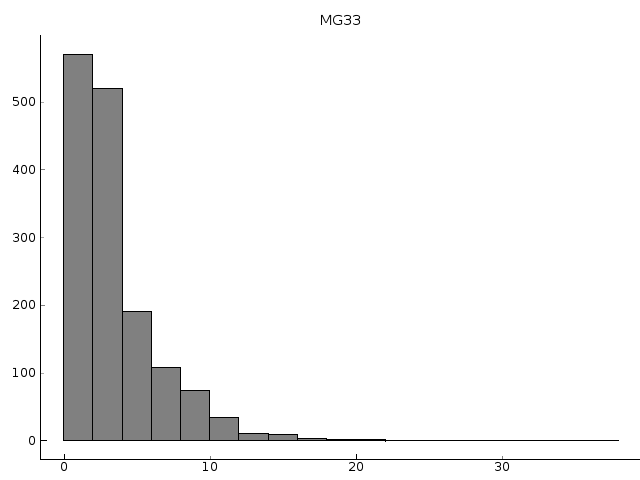

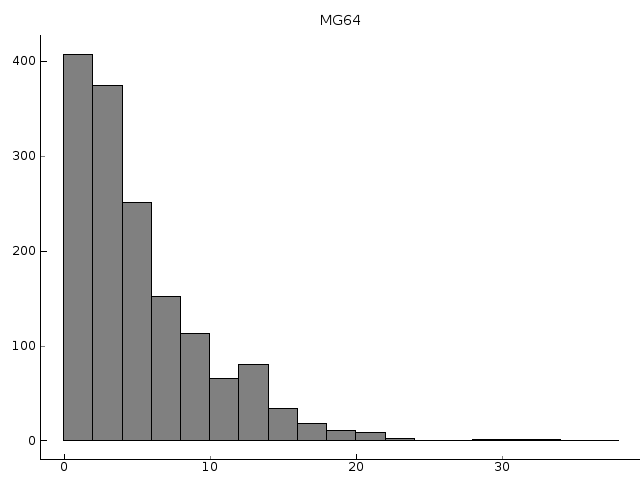

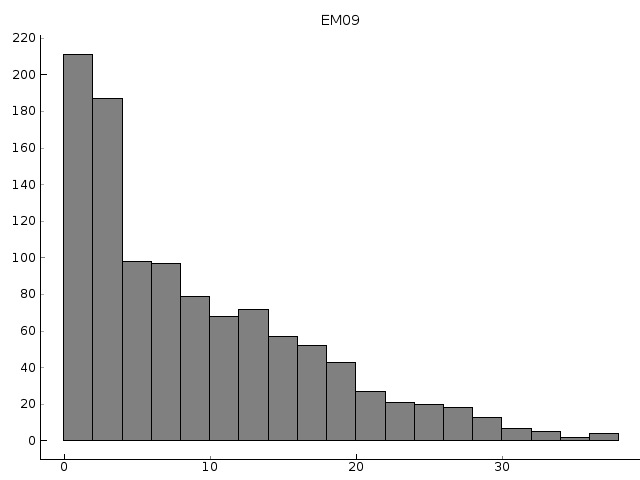

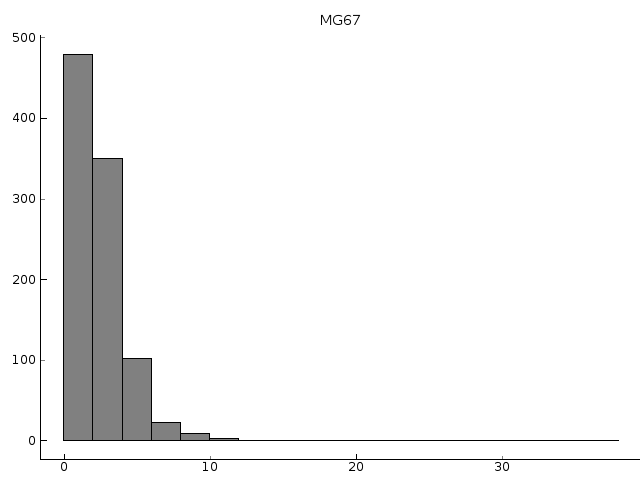

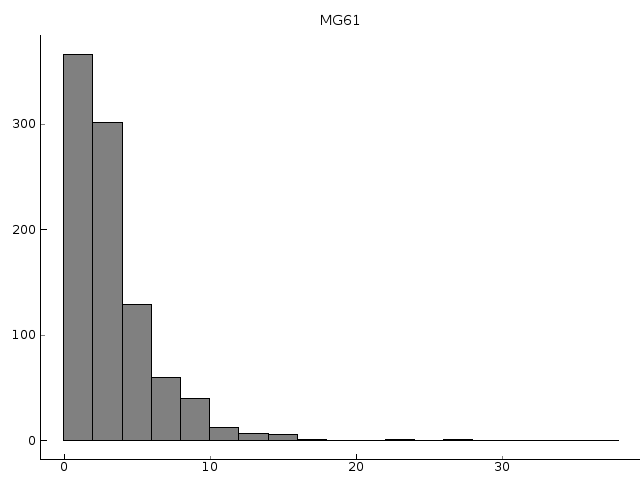

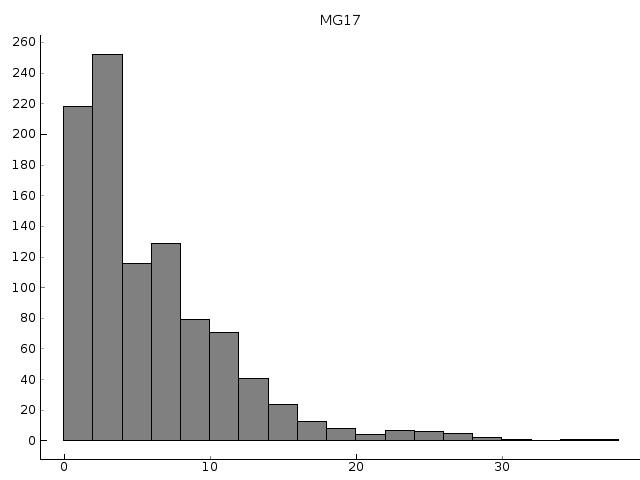

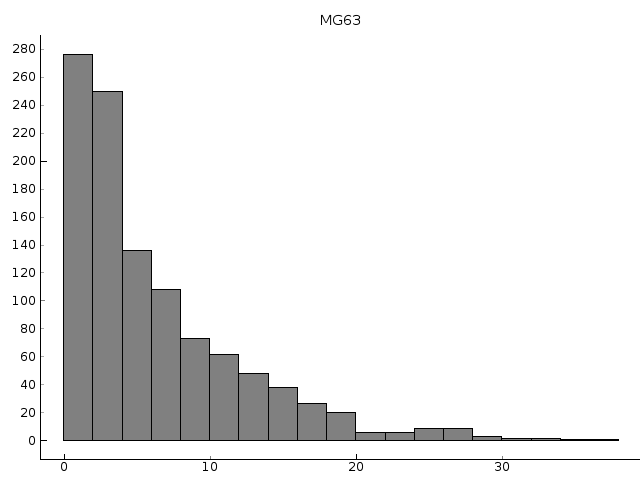

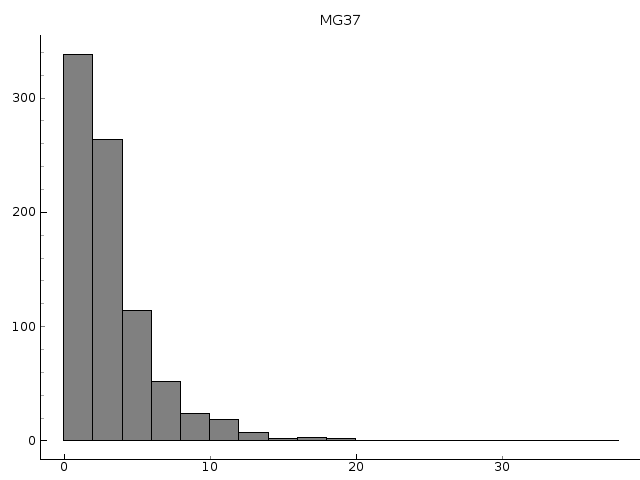

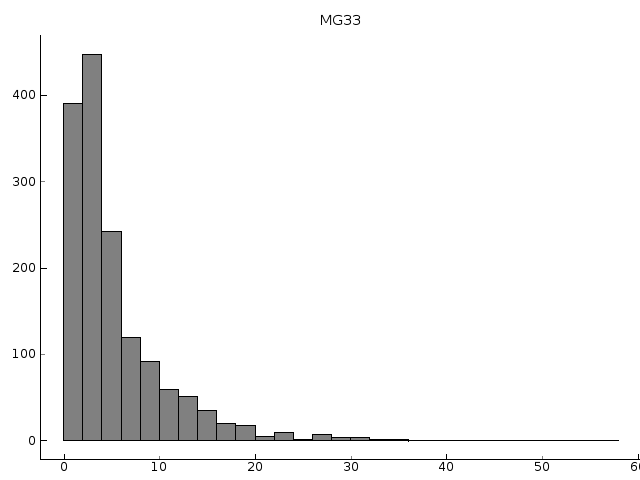

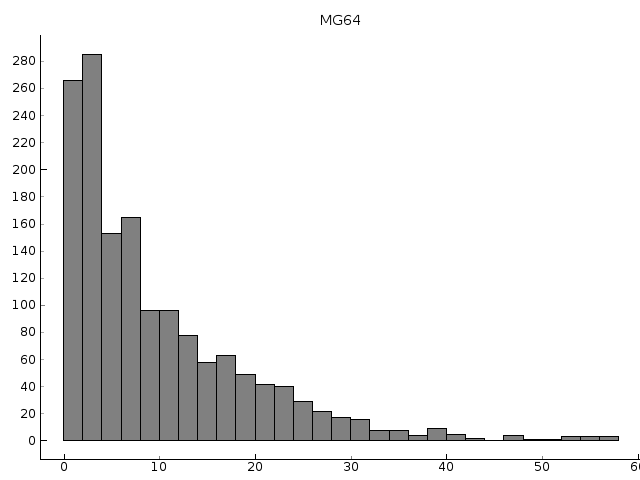

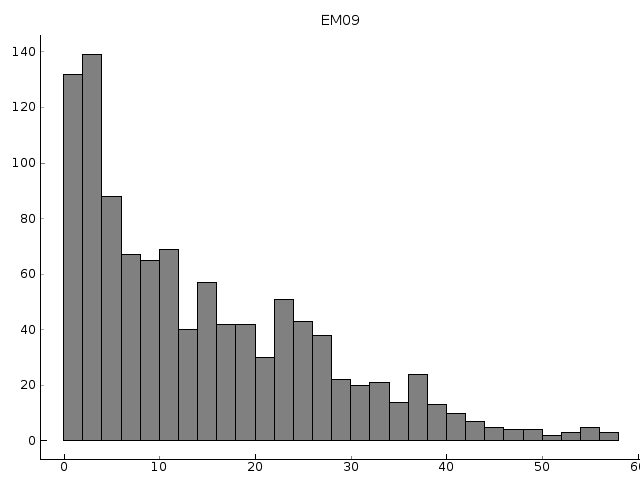

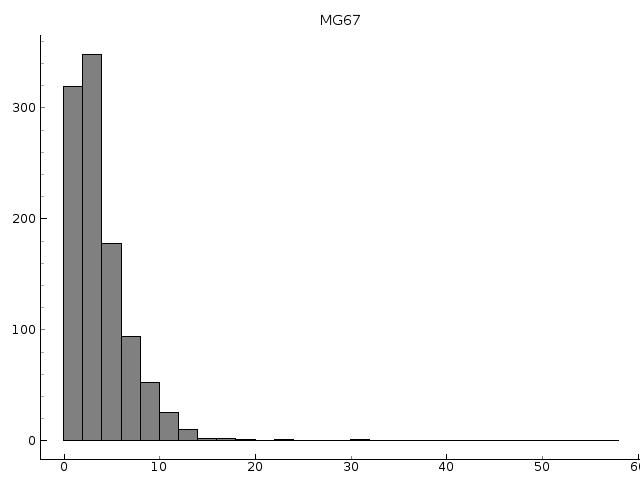

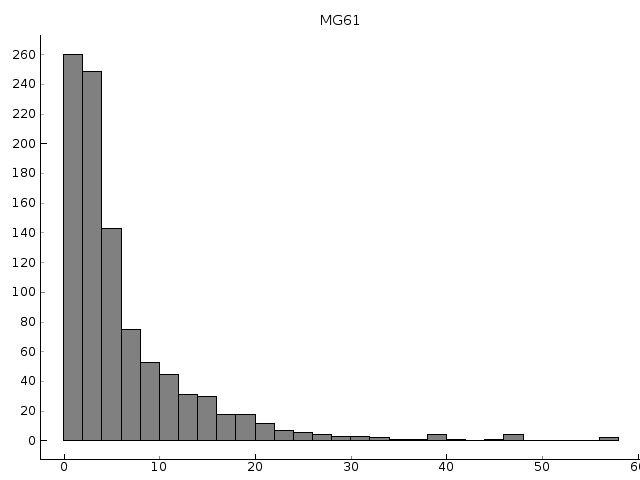

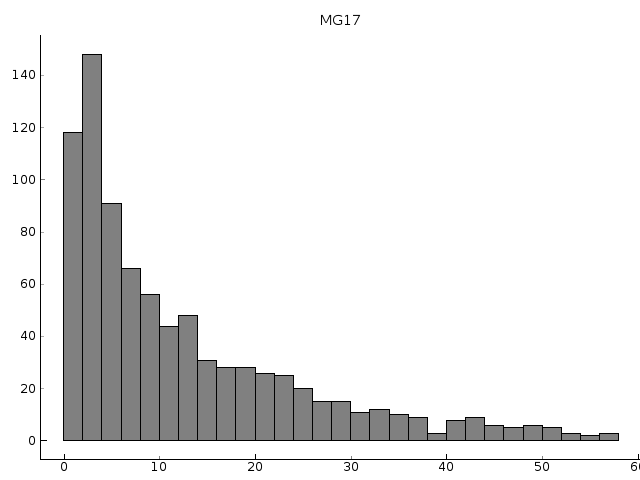

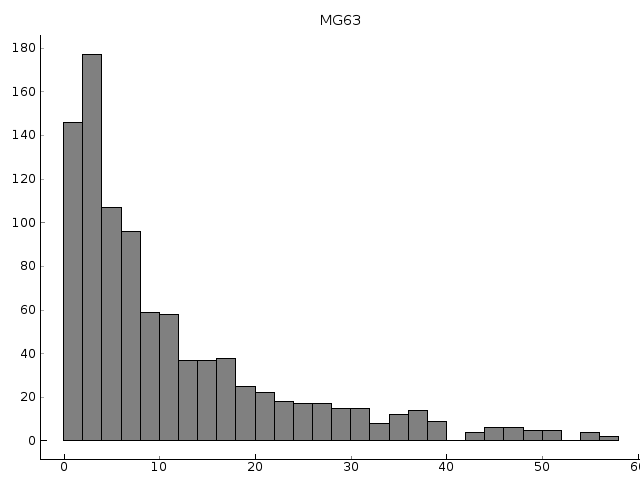

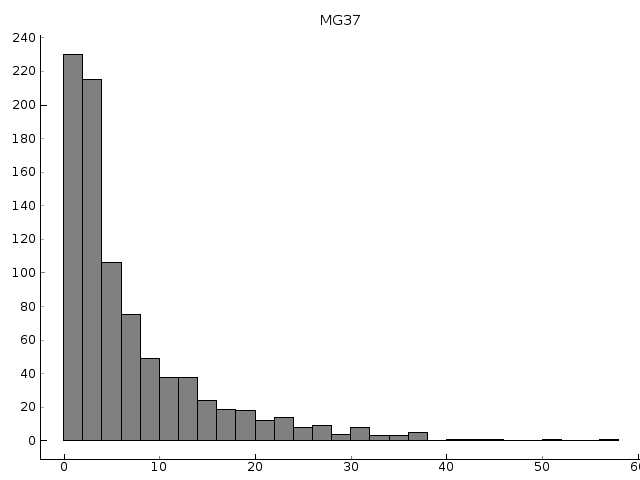

In [14]:
for REREF in ('avg', 15):
    for subj in HEMI_SUBJ:
        if REREF == 'avg':
            nchan = 40
        else:
            nchan = 60
        v = make_hist_overlap(subj, color=PLOT_COLOR, reref=REREF, width=2, nchan=nchan)
        v.save(str(images_dir.joinpath('hist_{}_{}.png'.format(REREF, subj))))
        display(v)

### Plots of common spindles

In [15]:
from spgr.constants import DATA_OPTIONS, HEMI_SUBJ, SPINDLE_OPTIONS, CHAN_TYPE
from spgr.detect_spindles import get_spindles
from spgr.read_data import get_chan_used_in_analysis
from spgr.spindle_source import get_morph_linear, get_chan_with_regions
from spgr.stats_on_spindles import create_spindle_groups, create_spindle_cooccurrence_matrix, mean_spindle_cooccurrence
from spgr.plot_spindles import plot_surf
from spgr.lmer_stats import lmer, lg
from logging import INFO
lg.setLevel(INFO)

In [16]:
images_dir = GROUP_PATH.joinpath('images').joinpath('cooccurrence_map')
if not images_dir.exists():
    images_dir.mkdir()

PLOT_COLOR = 'kw'

In [17]:
from numpy import mean, std

In [18]:
def add_to_dataframe(df, subj, values, chan):

    for one_chan, one_value in zip(chan.chan, values):
        region = one_chan.attr['region']
        if region[:3] == 'ctx':
            df['subj'].append(subj)
            df['region'].append(region[7:])
            df['elec'].append(one_chan.label)
            df['value'].append(one_value)

In [ ]:
lg.propagate = False
all_values = []

for REREF in ('avg', 15):
    for NORMALIZED_BY in ('source', 'target'):
        
        dataframe = {'subj': [], 'region': [], 'elec': [], 'value': []}
        for subj in HEMI_SUBJ:
            spindles = get_spindles(subj, reref=REREF, **SPINDLE_OPTIONS)
            spindle_group = create_spindle_groups(spindles)

            chan = get_chan_used_in_analysis(subj, 'sleep', chan_type=CHAN_TYPE, reref=REREF, **DATA_OPTIONS)
            chan_prob = create_spindle_cooccurrence_matrix(chan, spindle_group)
            chan_prob_per_chan = mean_spindle_cooccurrence(chan_prob, normalized_by=NORMALIZED_BY)

            morphed = get_morph_linear(subj, chan_prob_per_chan, reref=REREF)
            all_values.append(morphed)

            chan = get_chan_with_regions(subj, REREF)
            add_to_dataframe(dataframe, subj, chan_prob_per_chan, chan)    

        threshold = 0.01, None
        limits = 0, .2
        
        lg.propagate = True
        lmer(dataframe)
        lg.propagate = False

        v = plot_surf(all_values, threshold=threshold, limits=limits)
        png_name = 'cooccurrence_map_{}_{}.png'.format(NORMALIZED_BY, REREF)
        v.save(str(images_dir.joinpath(png_name)))
        display(v)
lg.propagate = True